In [1]:
import sys, os
sys.path.append('../src')
import numpy as np
from scipy import interpolate
from numba import jit, float64
import time, multiprocessing, pickle
from U1Funcs import DMvRatesGen
from StatisticFuncs import *
from WIMPFuncs import C_SI
from Params import *
from U1PlotFuncs import *

In [2]:
#========================== Experimental setup =========================================#
ne = 10 # number of energy bins
E_th = 1*1e-6 # Threshold GeV
E_max = 5*1e-6 # Max recoil energy GeV
Nuc = Xe131
#========================== Initialize fog =========================================#
fogGen=Fog()
#========================== Model and other parameters =================================#
selList=np.array([0,1,3])
b0Level=0.
mDM = 5.5

In [3]:
modelParaList = [[np.log10(2e-5),np.log10(30e-3),1,1,1],\
    [np.log10(4e-5),np.log10(20e-3),1/3,1/3,-1], [np.log10(8e-4),np.log10(16e-3),[0,1,-1]]]
paraGenList = [StatisticClass(SpectrumNR(6., E_th, E_max, ne, Nuc,modelParaList[0],selList),'SMvsDMNP'),\
               StatisticClass(SpectrumNR(6., E_th, E_max, ne, Nuc,modelParaList[1],selList),'DMvsNP'),\
               StatisticClass(SpectrumNR(6., E_th, E_max, ne, Nuc,modelParaList[2],selList,mode='FD'),'DMvsNP')]

[['0' 'hep']
 ['1' '8B']
 ['2' 'DSNB']
 ['3' 'Atm']
 ['4' 'Reactor']]
[['0' 'hep']
 ['1' '8B']
 ['2' 'DSNB']
 ['3' 'Atm']
 ['4' 'Reactor']]
[['0' 'hep']
 ['1' '8B']
 ['2' 'DSNB']
 ['3' 'Atm']
 ['4' 'Reactor']]


In [4]:
def myMul2(mDM, paraGenClass, FogGenClass, modelPara):
    exposureEndLog, dExpoLog, CL, b0Level = 8., 0.1, 0.9, 0.
    paraGenClass.setModel(modelPara)
    paraGenClass.setDMMass(mDM)
    NPDiscoveryExposure = biSearch(1., 8, findNPDiscoveryExposure, [paraGenClass, CL, b0Level], 0., 0)[0]
    #print([modelPara,NPDiscoveryExposure])
    paraList = exposureEndLog, dExpoLog, CL, b0Level, NPDiscoveryExposure
    return myMul(mDM, paraGenClass, FogGenClass, paraList)

# linux
# def resGen2(mDM, paraGenClass, FogGenClass, modelParaList):
#     time_start = time.perf_counter()
#     pool = multiprocessing.Pool(4)
#     multiple_results = [pool.apply_async(\
#             myMul2, [mDM, paraGenClass, FogGenClass, modelPara]) for modelPara in modelParaList]
#     pool.close()
#     pool.join()
#     res1= [res.get() for res in multiple_results]
#     time_end = time.perf_counter()
#     print("Time costed: {0} s.".format(time_end-time_start))
    
#     res1 = [item for item in res1]
#     modelMassList = 10**np.array([d[1] for d in modelParaList])
#     return [modelMassList, res1]

# windows
from joblib import Parallel, delayed
from tqdm import tqdm

def resGen2(mDM, paraGenClass, FogGenClass, modelParaList, n_jobs=20):
    time_start = time.perf_counter()

    # Define the function to be parallelized
    def parallel_function(modelPara, mDM, paraGenClass, FogGenClass):
        return myMul2(mDM, paraGenClass, FogGenClass, modelPara)

    # Use joblib to parallelize the computation and visualize the progress with tqdm
    results = Parallel(n_jobs=n_jobs)(delayed(parallel_function)(modelPara, mDM, paraGenClass, FogGenClass) for modelPara in tqdm(modelParaList))

    time_end = time.perf_counter()
    print("Time costed: {0} s.".format(time_end - time_start))

    modelMassList = 10**np.array([d[1] for d in modelParaList])
    return [modelMassList, results]

In [5]:
myMul2(mDM, paraGenList[0], fogGen, modelParaList[0])

[-44.69721697097137,
 [array([-42.8125    , -42.8625    , -42.96916667, -43.04179078,
         -43.10460082, -43.17904236, -43.24342422, -43.31972866,
         -43.38572168, -43.46393564, -43.53158014, -43.5900835 ,
         -43.6594208 , -43.7193882 , -43.79046068, -43.85192877,
         -43.92477983, -43.97438056, -44.06774663, -44.12016267,
         -44.18228538, -44.23601314, -44.29969047, -44.35476276,
         -44.40239285, -44.45884333, -44.5257476 , -44.57129944,
         -44.62528681, -44.68927184, -44.73283612, -44.78446785,
         -44.84566102, -44.88732445, -44.93670333, -44.99522645,
         -45.03507198, -45.08229631, -45.12313897, -45.15846236,
         -45.20032711, -45.23653447, -45.26784893, -45.29493172,
         -45.31835467, -45.33861235, -45.35613251, -45.37128508,
         -45.38439001, -45.395724  , -45.40344075, -45.41011471,
         -45.41588678, -45.42087884, -45.42427768, -45.42830595,
         -45.43178985, -45.43480296, -45.43740889, -45.4404974 ,
    

In [6]:
myPath = os.path.join(os.path.abspath(os.path.pardir),'data','detection')
U1UniversalLimitDat=np.transpose(np.log10(np.loadtxt(os.path.join(myPath,'U(1)UniversalLimit.txt'))))
U1UniversalLimitFunc = lambda mLog: np.interp(mLog, U1UniversalLimitDat[0], U1UniversalLimitDat[1])
U1BLLimitDat=np.transpose(np.log10(np.loadtxt(os.path.join(myPath,'U(1)BL.txt'))))
U1BLLimitFunc = lambda mLog: np.interp(mLog, U1BLLimitDat[0], U1BLLimitDat[1])
U1LmuLtauLimitDat=np.transpose(np.log10(np.loadtxt(os.path.join(myPath,'U(1)LmuLtau.txt'))))
U1LmuLtauLimitFunc = lambda mLog: np.interp(mLog, U1LmuLtauLimitDat[0], U1LmuLtauLimitDat[1])
[10**U1UniversalLimitFunc(np.log10(20e-3)),10**U1BLLimitFunc(np.log10(20e-3)),\
    10**U1LmuLtauLimitFunc(np.log10(20e-3))]

[2.2854831587645412e-05, 5.027088693857333e-05, 0.0009166954315114784]

In [7]:
colorList = ['r', 'b', 'g']
labelList = [r'U(1)$_{\rm Universal}$', r'U(1)$_{B-L}$',r'U(1)$_{L_\mu-L_\tau}$']

In [8]:
mLogList = np.linspace(np.log10(16e-3),np.log10(200e-3),20)
modelParaListUniversal = [[U1UniversalLimitFunc(mLog), mLog, 1,1,1] for mLog in mLogList]
resListUniversal = resGen2(mDM, paraGenList[0], fogGen, modelParaListUniversal)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 186.91it/s]


Time costed: 77.19080059998669 s.


In [9]:
mLogList = np.linspace(np.log10(16e-3),np.log10(200e-3),20)
modelParaListBL = [[U1BLLimitFunc(mLog), mLog, 1/3,1/3,-1] for mLog in mLogList]
resListBL = resGen2(mDM, paraGenList[1], fogGen, modelParaListBL)

100%|██████████| 20/20 [00:00<00:00, 19991.92it/s]


Time costed: 56.74881100002676 s.


In [10]:
mLogList = np.linspace(np.log10(16e-3),np.log10(50e-3),10)
modelParaListLmuLtau = [[U1LmuLtauLimitFunc(mLog), mLog, [0,1,-1]] for mLog in mLogList]
resListLmuLtau = resGen2(mDM, paraGenList[2], fogGen, modelParaListLmuLtau)

100%|██████████| 10/10 [00:00<00:00, 10402.54it/s]


Time costed: 49.912928299978375 s.


In [11]:
[maxCheck(res[0], res[1]) for res in [resListUniversal, resListBL, resListLmuLtau]]

[array([4.05737103e-02, 2.04516410e-45, 5.94819323e+02]),
 array([4.63422195e-02, 4.41811725e-45, 7.99457236e+02]),
 array([3.88153345e-02, 4.80446832e-46, 4.74935975e+02])]

In [12]:
PandaX4TLimitDat =np.transpose(loadtxt("../data/WIMPLimits/SI/PandaX4TDMLimits.txt"))
PandaX4TLimitFunc = lambda mDM: np.interp(mDM, PandaX4TLimitDat[0], PandaX4TLimitDat[1])
PandaX4TLimitFunc(mDM)

1.2052214973432405e-44

In [13]:
def ax1Func2(ax1, dat, color, label=False, rightLabel=False):
    n = 4
    colors = np.zeros([n,4])
    colors[0] = mpl.colors.to_rgba(color)
    colors[:] = mpl.colors.to_rgba(color)
    colors[:,3] = [0., 0.2, 0.5, 0.8]
    cmap = mpl.colors.ListedColormap(colors, name='test')
    m,sig,n = vsContourDatGen(dat[0], dat[1])
    cnt = ax1.contourf(m*1e3,sig,n,np.array([1., 10., 100., 300., 10000.]),\
                       colors=colors,antialiased=True)
    if label!=False:
        ax1.fill_between([-2,-1],[1,1],[2,2],color=color,alpha=0.5,label=label)
    # for c in cnt.collections:
    #     c.set_edgecolor(color)
    cnt.collections[1].set_edgecolor(color)
    if rightLabel:
        cmap2 = mpl.colors.ListedColormap(colors[1:-1], name='test')
        cmap2.set_under(color=color, alpha=0.)
        cmap2.set_over(color=color, alpha=0.8)
        im = plt.pcolormesh(-m,sig,n,vmax=3.,vmin=1,cmap=cmap2,rasterized=True,shading='auto')
        #fig.subplots_adjust(top=0.8)
        cbar_ax = fig.add_axes([0.912, 0.12, 0.03, 0.74])
        cbar = fig.colorbar(im, cax=cbar_ax,orientation='vertical',extend='max',extendfrac=0.08, \
                     ticks=[1,2,3])
        cbar.set_ticklabels([10,100,300])
        cbar_ax.yaxis.set_ticks_position('right')

C:\Users\ALoong\AppData\Local\Temp\ipykernel_16616\3545237575.py:15: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cnt.collections[1].set_edgecolor(color)
C:\Users\ALoong\AppData\Local\Temp\ipykernel_16616\3545237575.py:15: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  cnt.collections[1].set_edgecolor(color)


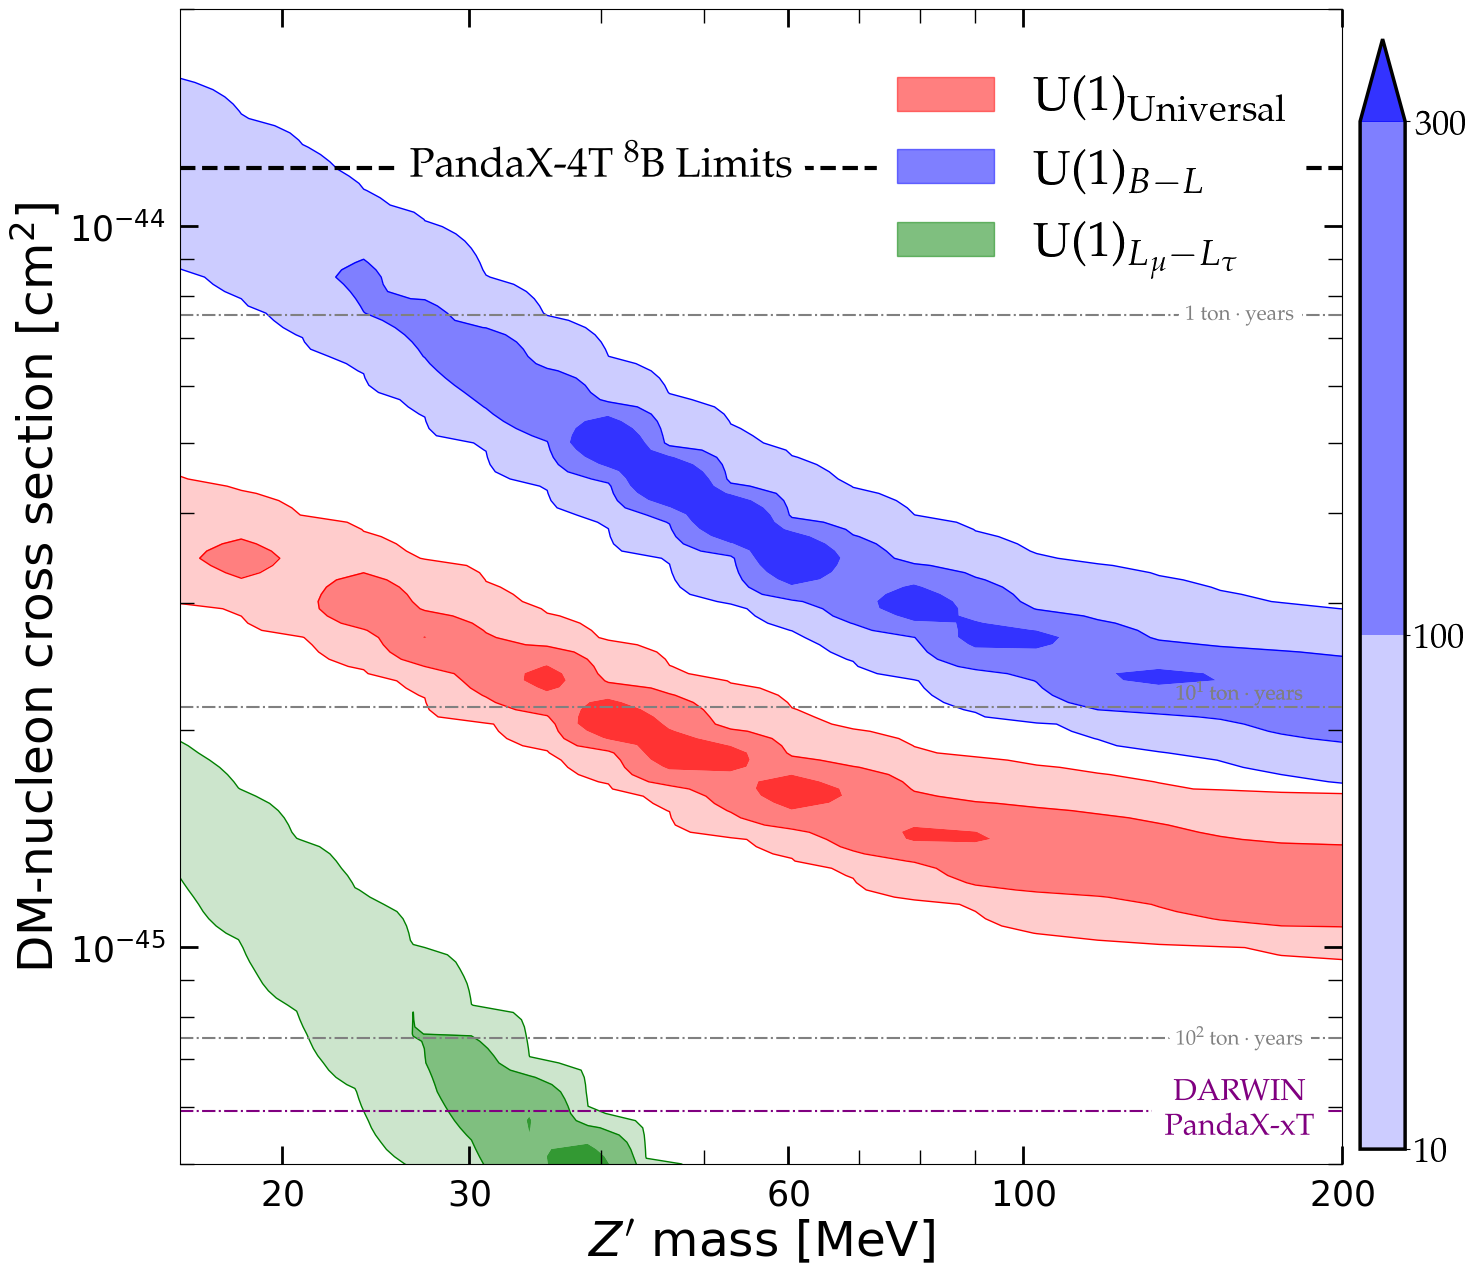

In [14]:
resList = [resListUniversal, resListBL, resListLmuLtau]

fig, ax1 = plt.subplots(figsize=(15,15))
# Plot style
lw, tfs = 2.5, 25
lfs = 35
plt.rcParams['axes.linewidth'] = lw
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'
#========================== exposure ============================================#
expoLogList = np.linspace(-1,4,6)
sigma0ContourList = 10**np.transpose([np.interp(expoLogList, d[1][1], d[1][0]) for d in resList[0][1]])
expoLogLabelList = [r"1 ${\rm ton}\cdot {\rm years}$"]+[r"$10^"+str(i)+r"$ ${\rm ton}\cdot {\rm years}$" \
                                                          for i in range(1,3)]
lines=[]
for i in range(len(expoLogLabelList)):
    l1 = ax1.loglog(resList[0][0]*1e3, sigma0ContourList[i], c='gray', linestyle='-.', label=expoLogLabelList[i])
    lines.extend(l1)

#labelLines(lines, xvals=170, fontsize=15, outline_width=13,drop_label=True)
labelLines([lines[0]], xvals=160, fontsize=15, outline_width=13,drop_label=True)
labelLines([lines[1]], xvals=160, fontsize=15, outline_width=0,drop_label=True,yoffsets=1e-46)
labelLines([lines[2]], xvals=160, fontsize=15, outline_width=13,drop_label=True)

sigma0ContourDARWIN = 10**np.array([np.interp(np.log10(20), d[1][1], d[1][0]) for d in resList[0][1]])
l1 = ax1.loglog(resList[0][0]*1e3,sigma0ContourDARWIN, c='purple',linestyle='-.', label="DARWIN\nPandaX-xT")
labelLines(l1, xvals=160, fontsize=22, outline_width=20,drop_label=True)
#========================== experiment ==========================================#
pek = line_background(7,'k')
l1=ax1.axhline(PandaX4TLimitFunc(5.5),c='black',lw=3,linestyle='--',label=r"PandaX-4T $^8$B Limits")
labelLines([l1], xvals=40, fontsize=30, outline_width=20,drop_label=True)
#========================== contour plot ========================================#
ax1Func2(ax1, resList[0], colorList[0],label=labelList[0])
ax1Func2(ax1, resList[1], colorList[1],label=labelList[1], rightLabel=True)
ax1Func2(ax1, resList[2], colorList[2],label=labelList[2])
ZprimeMassList = resList[0][0]*1e3
#========================== style ===============================================#
ax1.legend(fontsize=35,frameon=True,loc=(0.6,0.75),framealpha=1,fancybox=False,edgecolor=[1,1,1,0])
ax1.set_xlabel(r"$Z^\prime$ mass [MeV]",fontsize=lfs)
ax1.set_ylabel(r"DM-nucleon cross section [cm$^2$]",fontsize=lfs)
ax1.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=10,labelsize=25)
ax1.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax1.set_yticks(10.0**np.arange(-51,-30,1))
ax1.set_xlim(left=ZprimeMassList[0], right=ZprimeMassList[-1])
ax1.set_ylim(bottom=5e-46, top=2e-44)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.xaxis.set_major_locator(mticker.FixedLocator([2e1,3e1,6e1,1e2,2e2]))
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))

In [15]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
fig.savefig(os.path.join(myPathFig,"DMNSI_U1"+'.pdf'),bbox_inches='tight')
fig.savefig(os.path.join(myPathFig,'png','DMNSI_U1.png'),bbox_inches='tight')